In [141]:
%reload_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import re
import os
import sys
import time
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../")
from typing import List, Dict
from os.path import join, dirname
from pydrive.auth import GoogleAuth
from datetime import datetime
from utils import gdrive_downloader

In [2]:
GoogleAuth.DEFAULT_SETTINGS['client_config_file'] = '../../utils/client_secrets.json'
drive = gdrive_downloader.gdrive_authenticate()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=17797463459-h3beca6cno86q9eu3of312ki2g8dv7f5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
df_dict = gdrive_downloader.download_data(drive)
[{key: len(value)} for key, value in df_dict.items()]

pageviews
0.0
0.08888888888888889
0.17777777777777778
0.26666666666666666
0.35555555555555557
0.4444444444444444
0.5333333333333333
0.6222222222222222
0.7111111111111111
0.8
0.8888888888888888
0.9777777777777777
events
0.0
0.10869565217391304
0.21739130434782608
0.32608695652173914
0.43478260869565216
0.5434782608695652
0.6521739130434783
0.7608695652173914
0.8695652173913043
0.9782608695652174
commerce
0.0
0.10869565217391304
0.21739130434782608
0.32608695652173914
0.43478260869565216
0.5434782608695652
0.6521739130434783
0.7608695652173914
0.8695652173913043
0.9782608695652174


[{'pageviews': 14245014}, {'events': 4827199}, {'commerce': 67006}]

In [12]:
pageviews, events, commerce = [df for df in df_dict.values()]

Reformat pageviews dataframe

In [13]:
pageviews.rename(columns={'_article': 'is_article'}, inplace=True)
pageviews['article_id'].fillna('', inplace=True)
pageviews['is_article'] = pageviews['is_article'].astype(bool)
pageviews['article_id'] = pageviews['article_id'].astype(str)
pageviews['time'] = pd.to_datetime(pageviews['time'])
pageviews['date'] = pageviews['time'].dt.date
pageviews['remp_session_id'].fillna('', inplace = True)
pageviews['signed_in'].fillna('', inplace = True)
pageviews['social'].fillna('', inplace = True)
pageviews['tags'].fillna('', inplace = True)
pageviews['title'].fillna('', inplace = True)
pageviews['user_agent'].fillna('', inplace = True)
[pageviews[column].fillna('', inplace = True) for column in pageviews.columns if re.search('utm_', column) is not None]
pageviews.head()

,is_article,action,article_id,category,host,name,referer,remp_session_id,signed_in,social,...,title_variant,token,url,user_agent,user_id,utm_campaign,utm_content,utm_medium,utm_source,date
0,True,load,6734.0,nezaradene,npress-influxdb-n2.ewhs.bntb.net,pageviews,NaN,6b60d544-53b4-4524-ad7a-06ce791ffa3b,0,,...,A,1a8feb16-3e30-4f9b-bf74-20037ea8505a,https://dennikn.sk/6734/biznis-s-titulmi-kto-p...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2dfb3791-a51c-4c7a-819d-f7a94a29c015,,,,,2018-02-03
1,True,load,165977.0,veda,npress-influxdb-n2.ewhs.bntb.net,pageviews,NaN,6b60d544-53b4-4524-ad7a-06ce791ffa3b,0,,...,A,1a8feb16-3e30-4f9b-bf74-20037ea8505a,https://dennikn.sk/165977/zivocisne-druhy-maso...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2dfb3791-a51c-4c7a-819d-f7a94a29c015,,,,,2018-02-03
2,True,load,594122.0,komentare,npress-influxdb-n2.ewhs.bntb.net,pageviews,NaN,6b60d544-53b4-4524-ad7a-06ce791ffa3b,0,,...,A,1a8feb16-3e30-4f9b-bf74-20037ea8505a,https://dennikn.sk/594122/mohamedov-zivot/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2dfb3791-a51c-4c7a-819d-f7a94a29c015,,,,,2018-02-03
3,True,load,808523.0,hlavna,npress-influxdb-n2.ewhs.bntb.net,pageviews,NaN,6b60d544-53b4-4524-ad7a-06ce791ffa3b,0,,...,A,1a8feb16-3e30-4f9b-bf74-20037ea8505a,https://dennikn.sk/minuta/808523/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2dfb3791-a51c-4c7a-819d-f7a94a29c015,,,,,2018-02-03
4,True,load,859254.0,hlavna,npress-influxdb-n2.ewhs.bntb.net,pageviews,NaN,6b60d544-53b4-4524-ad7a-06ce791ffa3b,0,,...,A,1a8feb16-3e30-4f9b-bf74-20037ea8505a,https://dennikn.sk/minuta/859254/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2dfb3791-a51c-4c7a-819d-f7a94a29c015,,,,,2018-02-03


Reformat commerce dataframe

In [43]:
commerce.head()

,article_id,author_id,currency,funnel_id,host,name,product_ids,revenue,step,time,token,transaction_id,url,user_agent,user_id,utm_campaign,utm_content,utm_medium,utm_source
0,,,,28,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,1517616636000000000,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,23763,,,,
1,,,,shop,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,1517616800000000000,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,141551,,,,
2,,,EUR,shop,npress-influxdb-n2.ewhs.bntb.net,commerce,"38,43,47",39.74,payment,1517616865000000000,1a8feb16-3e30-4f9b-bf74-20037ea8505a,8577694016,https://obchod.dennikn.sk/,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,141551,,,,
3,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,84,4.99,purchase,1517616905000000000,1a8feb16-3e30-4f9b-bf74-20037ea8505a,6630687496,,,16143,,,,
4,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,1517616991000000000,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,133214,,,,


In [17]:
commerce_test = df_dict['commerce']

In [38]:
print(commerce.columns)
commerce['time'] = pd.to_datetime(commerce['time'].astype(int))
commerce['date'] = commerce['time'].dt.date
for column in commerce.columns:
    if column not in ['revenue']:
        commerce[column] = commerce[column].astype(str)
        commerce[column] = commerce[column].str.replace('nan', '')
    else:
        commerce['revenue'] = commerce['revenue'].astype(float)
        commerce['revenue'] = commerce['revenue'].fillna(0)
commerce.head()

Index(['article_id', 'author_id', 'currency', 'funnel_id', 'host', 'name',
       'product_ids', 'revenue', 'step', 'time', 'token', 'transaction_id',
       'url', 'user_agent', 'user_id', 'utm_campaign', 'utm_content',
       'utm_medium', 'utm_source'],
      dtype='object')


,article_id,author_id,currency,funnel_id,host,name,product_ids,revenue,step,time,token,transaction_id,url,user_agent,user_id,utm_campaign,utm_content,utm_medium,utm_source,date
0,,,,28,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-02-03 00:10:36,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,23763,,,,,2018-02-03
1,,,,shop,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-02-03 00:13:20,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,141551,,,,,2018-02-03
2,,,EUR,shop,npress-influxdb-n2.ewhs.bntb.net,commerce,"38,43,47",39.74,payment,2018-02-03 00:14:25,1a8feb16-3e30-4f9b-bf74-20037ea8505a,8577694016,https://obchod.dennikn.sk/,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,141551,,,,,2018-02-03
3,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,84,4.99,purchase,2018-02-03 00:15:05,1a8feb16-3e30-4f9b-bf74-20037ea8505a,6630687496,,,16143,,,,,2018-02-03
4,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-02-03 00:16:31,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,133214,,,,,2018-02-03


In [40]:
last_30_days = pd.Series(pageviews['date'].unique()).sort_values(ascending=False).tolist()[:30]

Comparing with funnel report built in Exponea @ https://cloud.infinario.com/p/dennikn-sk/analytics/funnels/5a76c32534e299737da62ffb

In [41]:
print('Unique visitors, last 30 days: ')
print('REMP data collection: ', len(pageviews.loc[pageviews['date'].isin(last_30_days), 'user_id'].unique()))
print('Exponea: 1126722')

Unique visitors, last 30 days: 
REMP data collection:  984895
Exponea: 1126722


In [137]:
print('Unique visitors on articles, last 30 days: ')
print('REMP data collection: ', len(df_dict['pageviews'].loc[(pageviews['date'].isin(last_30_days)) &
                                                             (pageviews['is_article'] == True), 'user_id'].unique()))
print('Exponea: 519 050')

Unique visitors on articles, last 30 days: 
REMP data collection:  844545
Exponea: 519 050


In [53]:
print('Unique visitors in sales funnel, last 30 days: ')
print('REMP data collection: ', len(commerce.loc[(commerce['date'].isin([x.isoformat() for x in last_30_days])), 'user_id'].unique()))
print('Exponea: 32')

Unique visitors in sales funnel, last 30 days: 
REMP data collection:  20290
Exponea: 32


In [59]:
print('Unique visitors signed in, last 30 days: ')
print('REMP data collection: ', len(pageviews.loc[(pageviews['date'].isin(last_30_days)) &
                                                  (pageviews['user_id'].str.match('^[0-9]+$')), 'user_id'].unique()))
print('Exponea: 67001')

Unique visitors signed in, last 30 days: 
REMP data collection:  46775
Exponea: 67001


In [61]:
print('Unique visitors on articles signed in, last 30 days: ')
print('REMP data collection: ', len(df_dict['pageviews'].loc[(pageviews['date'].isin(last_30_days)) &
                                                             (pageviews['is_article'] == True) &
                                                             (pageviews['user_id'].str.match('^[0-9]+$')), 'user_id'].unique()))
print('Exponea: 55558')

Unique visitors on articles signed in, last 30 days: 
REMP data collection:  45983
Exponea: 55558


In [62]:
print('Unique visitors in sales funnel signed in, last 30 days: ')
print('REMP data collection: ', len(commerce.loc[(commerce['date'].isin([x.isoformat() for x in last_30_days])) &
                                                 (commerce['user_id'].str.match('^[0-9]+$')), 'user_id'].unique()))
print('Exponea: 28')

Unique visitors in sales funnel signed in, last 30 days: 
REMP data collection:  19622
Exponea: 28


Comparing with engagement reports (all pageviews) @ https://cloud.infinario.com/p/dennikn-sk/analytics/funnels/5a7700dc34e299737da63001

In [94]:
readership_level_all_remp = pd.Series(pageviews['user_id'].value_counts()).value_counts(normalize=True)
readership_level_all_exponea = pd.Series.from_csv('readership-levels-all-pvs.csv')[2:].astype(int)
readership_level_all_exponea = readership_level_all_exponea / readership_level_all_exponea.sum()
readership_level_all_exponea.index = readership_level_all_exponea.index.astype(int)
readership_level_all_exponea = readership_level_all_exponea.sort_index()

For the sake of chart simplicity we bin all users accessing more than 10 pageviews into a 10+ category

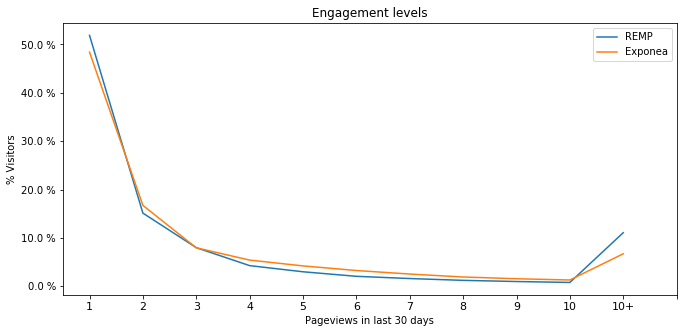

In [136]:
plt.clf()
remp_readership_all = readership_level_all_remp[:10].append(pd.Series(readership_level_all_remp[10:].sum())).reset_index(drop=True)
# remp_readership_all.index = [str(x) for x in range(1, 11)] + ['10+']
exponea_readership_all = readership_level_all_exponea[:10].append(pd.Series(readership_level_all_exponea[10:].sum())).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(11, 5))
plt.plot(remp_readership_all)
plt.plot(exponea_readership_all)
vals = ax.get_yticks()
ax.set_yticklabels([str(x*100) + ' %' for x in vals])
ax.set_xticks(range(0,12))
ax.set_xticklabels(pd.Series([(str(val) if val != 11 else '10+')  
                              for val in range(1,12)]), fontsize=11)
ax.legend(('REMP', 'Exponea'))
plt.xlabel("Pageviews in last 30 days")
plt.ylabel("% Visitors")
plt.title('Engagement levels')
plt.show()

It seems the engagement levels are pretty close, the difference in long tail is most likely caused by Exponea counting cookies while REMP data collection collects cookies for anonymous users and customer ids for signed in users, which means the long tail is used by account sharing and / or multiple devices per paying users

In [131]:
readership_level_articles_remp = pd.Series(pageviews['user_id'].value_counts()).value_counts(normalize=True)
readership_level_articles_exponea = pd.Series.from_csv('readership-levels-articles.csv')[2:].astype(int)
readership_level_articles_exponea = readership_level_articles_exponea / readership_level_articles_exponea.sum()
readership_level_articles_exponea.index = readership_level_articles_exponea.index.astype(int)
readership_level_articles_exponea = readership_level_articles_exponea.sort_index()

Binning again occurs for readers reading more than 10 articles within last 30 days

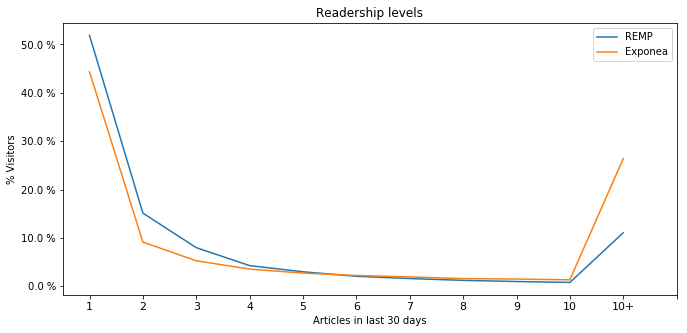

In [135]:
plt.clf()
remp_readership_articles = readership_level_articles_remp[:10].append(pd.Series(readership_level_articles_remp[10:].sum())).reset_index(drop=True)
# remp_readership_all.index = [str(x) for x in range(1, 11)] + ['10+']
exponea_readership_articles = readership_level_articles_exponea[:10].append(pd.Series(readership_level_articles_exponea[10:].sum())).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(11, 5))
plt.plot(remp_readership_articles)
plt.plot(exponea_readership_articles)
vals = ax.get_yticks()
ax.set_yticklabels([str(x*100) + ' %' for x in vals])
ax.set_xticks(range(0,12))
ax.set_xticklabels(pd.Series([(str(val) if val != 11 else '10+')  
                              for val in range(1,12)]), fontsize=11)
ax.legend(('REMP', 'Exponea'))
plt.xlabel("Articles in last 30 days")
plt.ylabel("% Visitors")
plt.title('Readership levels')
plt.show()

The data for articles only seem to follow the same trend as for all pageviews

As a last part of this comparison we're going to look into purchases in commerce data and in the mysql DB

In [138]:
mysql_connection_string = 'mysql://root@localhost:3306'

In [142]:
def create_connection(autocommit=True):
    engine = sqlalchemy \
        .create_engine(
            mysql_connection_string
        )

    connection = engine \
        .connect() \
        .execution_options(autocommit=True)

    return engine, connection


engine, mysql = create_connection()

/usr/local/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py:1543: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


NOTE: remp_20180122073050 is my local name for the DB, in order to run this select you need to use a different name (also a different connection string)

In [176]:
query_string = sqlalchemy.sql.text('''
                                    SELECT
                                        user_id,
                                        id as payment_id,
                                        DATE(created_at) AS purchase_date
                                    FROM
                                        remp_20180122073050.payments
                                    WHERE
                                        DATE(created_at) >= STR_TO_DATE(:min_date, '%Y-%m-%d')
                                        AND DATE(created_at) <= STR_TO_DATE(:max_date, '%Y-%m-%d')
                                        AND status = 'paid'
                                        ''')
query = mysql.execute(query_string, 
                      min_date=str(last_30_days[-1]), 
                      max_date=str(last_30_days[0]))
payments = pd.DataFrame(query.fetchall())
payments.columns = query.keys()
payments.head()

,user_id,payment_id,purchase_date
0,89462,478117,2018-01-04
1,86156,478118,2018-01-04
2,28152,478124,2018-01-04
3,69610,478128,2018-01-04
4,81256,478129,2018-01-04


In [187]:
(len(commerce[
    (commerce['date'].isin([x.isoformat() for x in last_30_days])) &
    (commerce['user_id'].isin(payments['user_id'].astype(str).unique())) &
    (commerce['step'] == 'purchase')]) /
len(commerce[commerce['step'] == 'purchase']))

0.3913554836812702

In [175]:
commerce[commerce['user_id'] == '1238']

,article_id,author_id,currency,funnel_id,host,name,product_ids,revenue,step,time,token,transaction_id,url,user_agent,user_id,utm_campaign,utm_content,utm_medium,utm_source,date
841,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-03 11:34:25,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,card_expires_this_month,,email,system,2018-01-03
854,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-03 11:41:34,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,card_expires_this_month,,email,system,2018-01-03
1836,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-03 23:20:43,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,,,,,2018-01-03
531,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-05 09:50:30,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,,,,,2018-01-05
533,,,EUR,19,npress-influxdb-n2.ewhs.bntb.net,commerce,52,53.88,payment,2018-01-05 09:50:52,1a8feb16-3e30-4f9b-bf74-20037ea8505a,3024968075.0,https://dennikn.sk/989295/ked-trump-vyhral-mel...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1238,,,,,2018-01-05
537,989295.0,Tomáš Vasilko,EUR,19,npress-influxdb-n2.ewhs.bntb.net,commerce,52,53.88,purchase,2018-01-05 09:52:58,1a8feb16-3e30-4f9b-bf74-20037ea8505a,3024968075.0,https://dennikn.sk/989295/ked-trump-vyhral-mel...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1238,,,,,2018-01-05
1224,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-04 17:16:43,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,cardfail01_issuing_bank,,email,system,2018-01-04
1228,,,EUR,19,npress-influxdb-n2.ewhs.bntb.net,commerce,52.0,53.88,payment,2018-01-04 17:18:03,1a8feb16-3e30-4f9b-bf74-20037ea8505a,8460356528.0,https://predplatne.dennikn.sk/sales-funnel/sal...,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_1 like...,1238,cardfail01_issuing_bank,,email,system,2018-01-04
1229,,,EUR,19,npress-influxdb-n2.ewhs.bntb.net,commerce,52.0,53.88,payment,2018-01-04 17:18:05,1a8feb16-3e30-4f9b-bf74-20037ea8505a,5822567992.0,https://predplatne.dennikn.sk/sales-funnel/sal...,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_1 like...,1238,cardfail01_issuing_bank,,email,system,2018-01-04
63,,,,19,npress-influxdb-n2.ewhs.bntb.net,commerce,,0.00,checkout,2018-01-01 07:56:42,1a8feb16-3e30-4f9b-bf74-20037ea8505a,,,,1238,card_expires_this_month,,email,system,2018-01-01


In [174]:
payments[payments['user_id'].astype(str) == '1238']

,user_id,payment_id,purchase_date
0,1238,478116,2018-01-04
11,1238,478127,2018-01-04
87,1238,478203,2018-01-04
396,1238,478512,2018-01-04
681,1238,478797,2018-01-04
683,1238,478799,2018-01-04
684,1238,478800,2018-01-04
1116,1238,479232,2018-01-05


In [171]:
commerce[commerce['step'] == 'purchase'].head()

,article_id,author_id,currency,funnel_id,host,name,product_ids,revenue,step,time,token,transaction_id,url,user_agent,user_id,utm_campaign,utm_content,utm_medium,utm_source,date
3,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,84,4.99,purchase,2018-02-03 00:15:05,1a8feb16-3e30-4f9b-bf74-20037ea8505a,6630687496,,,16143,,,,,2018-02-03
5,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,"38,43,47",39.74,purchase,2018-02-03 00:18:03,1a8feb16-3e30-4f9b-bf74-20037ea8505a,8577694016,https://obchod.dennikn.sk/,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,141551,,,,,2018-02-03
11,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,2,8.90,purchase,2018-02-03 01:30:06,1a8feb16-3e30-4f9b-bf74-20037ea8505a,2081313780,,,10740,,,,,2018-02-03
22,1017282.0,Dušan Mikušovič,EUR,19,npress-influxdb-n2.ewhs.bntb.net,commerce,52,53.88,purchase,2018-02-03 01:41:43,1a8feb16-3e30-4f9b-bf74-20037ea8505a,7993945396,https://dennikn.sk/1017282/hlasov-proti-zmene-...,Mozilla/5.0 (Linux; Android 6.0.1; ONE E1003 B...,28600,,,,,2018-02-03
30,,,EUR,,npress-influxdb-n2.ewhs.bntb.net,commerce,1,4.90,purchase,2018-02-03 03:45:08,1a8feb16-3e30-4f9b-bf74-20037ea8505a,1724211213,,,18326,,,,,2018-02-03
